# Ratio of girls to boys in education, data analysis

This dataset contains information on the ratio of girls to boys in different stages of education: primary, secondary and tertiary. The data is also divided by region or country, and includes a world average.

Here I will try to clean, analyse and visualize the available data with the purpose of clear understanding of the progress made in girls education across the world since 1985, the earliest available year in our data.

## Data cleaning and preparation

First I will start by importing the necessary modules and initializing a SparkContext object

In [1]:
import pandas as pd,seaborn as sns,matplotlib.pyplot as plt
import geopandas as gpd
import json
import sqlite3

# Find path to PySpark.
import findspark
findspark.init()
# Import PySpark and initialize SparkContext object.
import pyspark
from pyspark.sql import SQLContext
sc = pyspark.SparkContext()
sqlCtx = SQLContext(sc)


Creating a Spark dataframe:

In [2]:
df = sqlCtx.read.csv(r'C:\Users\juanv\Desktop\Programming\Projects\Datasets\education_girls.csv')
#Create Spark SQL table
df.createOrReplaceTempView('education')
sqlCtx.sql('select * from education').show()

+-------------------+--------------------+----+--------------------+------+---------+--------------------+
|                _c0|                 _c1| _c2|                 _c3|   _c4|      _c5|                 _c6|
+-------------------+--------------------+----+--------------------+------+---------+--------------------+
|                T06|Ratio of girls to...|null|                null|  null|     null|                null|
|Region/Country/Area|                null|Year|              Series| Value|Footnotes|              Source|
|                753|Eastern and South...|1985|Ratio of girls to...|0.8770|     null|United Nations Ed...|
|                753|Eastern and South...|1995|Ratio of girls to...|0.9580|     null|United Nations Ed...|
|                753|Eastern and South...|2005|Ratio of girls to...|0.9894|Estimate.|United Nations Ed...|
|                753|Eastern and South...|2010|Ratio of girls to...|0.9934|     null|United Nations Ed...|
|                753|Eastern and Sout

The columns have a weird name, lets change them to a better name to work with

In [3]:
#Rename columns
df2 = df.withColumnRenamed("_c0","id").withColumnRenamed("_c1","region").withColumnRenamed("_c2","year").withColumnRenamed("_c3","education_type").withColumnRenamed("_c4","value").withColumnRenamed("_c5","footnotes").withColumnRenamed("_c6","source")
df2.createOrReplaceTempView('education')
sqlCtx.sql('select * from education').show()

+-------------------+--------------------+----+--------------------+------+---------+--------------------+
|                 id|              region|year|      education_type| value|footnotes|              source|
+-------------------+--------------------+----+--------------------+------+---------+--------------------+
|                T06|Ratio of girls to...|null|                null|  null|     null|                null|
|Region/Country/Area|                null|Year|              Series| Value|Footnotes|              Source|
|                753|Eastern and South...|1985|Ratio of girls to...|0.8770|     null|United Nations Ed...|
|                753|Eastern and South...|1995|Ratio of girls to...|0.9580|     null|United Nations Ed...|
|                753|Eastern and South...|2005|Ratio of girls to...|0.9894|Estimate.|United Nations Ed...|
|                753|Eastern and South...|2010|Ratio of girls to...|0.9934|     null|United Nations Ed...|
|                753|Eastern and Sout

The first two rows dont contain any important data, better drop them

In [4]:
df2.count()

2911

In [5]:
df3 = sqlCtx.sql('SELECT * FROM education WHERE source IS NOT null AND region IS NOT null')
df3.count()

2909

From 2911 rows to 2909 rows, so we know is correct.

The columns footnotes and source are both unnecessary for this analysis, lets drop them:

In [6]:
df4 = df3.drop('footnotes').drop('source')

In [7]:
df4.createOrReplaceTempView('education')
sqlCtx.sql('select * from education').show()

+---+--------------------+----+--------------------+------+
| id|              region|year|      education_type| value|
+---+--------------------+----+--------------------+------+
|753|Eastern and South...|1985|Ratio of girls to...|0.8770|
|753|Eastern and South...|1995|Ratio of girls to...|0.9580|
|753|Eastern and South...|2005|Ratio of girls to...|0.9894|
|753|Eastern and South...|2010|Ratio of girls to...|0.9934|
|753|Eastern and South...|2015|Ratio of girls to...|0.9923|
|753|Eastern and South...|2016|Ratio of girls to...|0.9942|
|753|Eastern and South...|2017|Ratio of girls to...|0.9949|
|753|Eastern and South...|1985|Ratio of girls to...|0.7925|
|753|Eastern and South...|1995|Ratio of girls to...|0.8975|
|753|Eastern and South...|2005|Ratio of girls to...|0.9853|
|753|Eastern and South...|2010|Ratio of girls to...|1.0003|
|753|Eastern and South...|2015|Ratio of girls to...|1.0155|
|753|Eastern and South...|2016|Ratio of girls to...|1.0195|
|753|Eastern and South...|2017|Ratio of 

The values in the education_type column look a bit ugly, lets update them to a better format.

From previous experience I know that Spark SQL doesnt have an UPDATE statement yet. There are possible workarounds for this issue, but I believe is just better to convert the Spark dataframe to a Pandas dataframe, considering we are working with very little data.

Converting to a pandas dataframe and creating a SQLite3 table:

In [8]:
#From Spark dataframe to Pandas to SQLite3 table
pd_df = df4.toPandas()
conn = sqlite3.connect('education_cleaned.db')
cursor = conn.cursor()
pd_df.to_sql(name = "education_cleaned",con=conn)
#Update the values of the education_type columns to a cleaner format
cursor.execute("UPDATE education_cleaned SET education_type = 'primary' WHERE education_type LIKE '%primary%'")
cursor.execute("UPDATE education_cleaned SET education_type = 'secondary' WHERE education_type LIKE '%secondary%'")
cursor.execute("UPDATE education_cleaned SET education_type = 'tertiary' WHERE education_type LIKE '%tertiary%'")
#Using pd.read_sql_query function to create a dataframe based on a SQL query
average_2015 = pd.read_sql_query("SELECT id,region, AVG(value) as average_ratio FROM education_cleaned WHERE year = 2015 GROUP BY id ORDER BY average_ratio",conn)
average_2015

,id,region,average_ratio
0,148,Chad,0.613350
1,728,South Sudan,0.622600
2,4,Afghanistan,0.627450
3,562,Niger,0.657333
4,204,Benin,0.682067
...,...,...,...
184,662,Saint Lucia,1.446550
185,60,Bermuda,1.471267
186,516,Namibia,1.749700
187,533,Aruba,2.263600


As is shown above is very comfortable to create a Pandas dataframe from a SQL query!

To distinguish between countries and regions I will create tuples with the id of each

In [9]:
regions_id = ("1","15","202","21","143","30","35","34","145","150","9","419")
world_id = ("1")
ids = list(average_2015.id.unique())
countries_id = [i for i in ids if i not in regions_id]
countries_id = (countries_id)

And then I will use .format to be able to use variables in a SQL query. This will allow me to use the previous tuples to filter between regions, countries, and the world total.

In [10]:
#Using .format to use variables in the SQL query. This way it will only find countries in the regions_id tuple.
query = "SELECT id, region, year, AVG(value) as average_ratio FROM education_cleaned WHERE id IN ({1}) AND year = 2015 GROUP BY id ORDER BY average_ratio"
query = query.format("?",",".join("?"*len(regions_id)))
regions_2015 = pd.read_sql_query(query,conn,params=regions_id)

I will create a function to simplify the above code:

In [11]:
def sql_to_df(query,id_filter):
    """ Function to create a dataframe from a SQL query
    
    Args:
        query (str): A SQL query to retrieve information from the desired table
        id_filter (tuple): A tuple with the desired ids to filter the table
    
    Returns:
        df (DataFrame): returns a dataframe object with the name of df
        
    """
    query = query.format("?",",".join("?"*len(id_filter)))
    df = pd.read_sql_query(query,conn,params=id_filter)
    return df

## Data analysis

Now that we have created a clean SQL table and we have tuples to filter countries from regions we can proceed to analyse the data

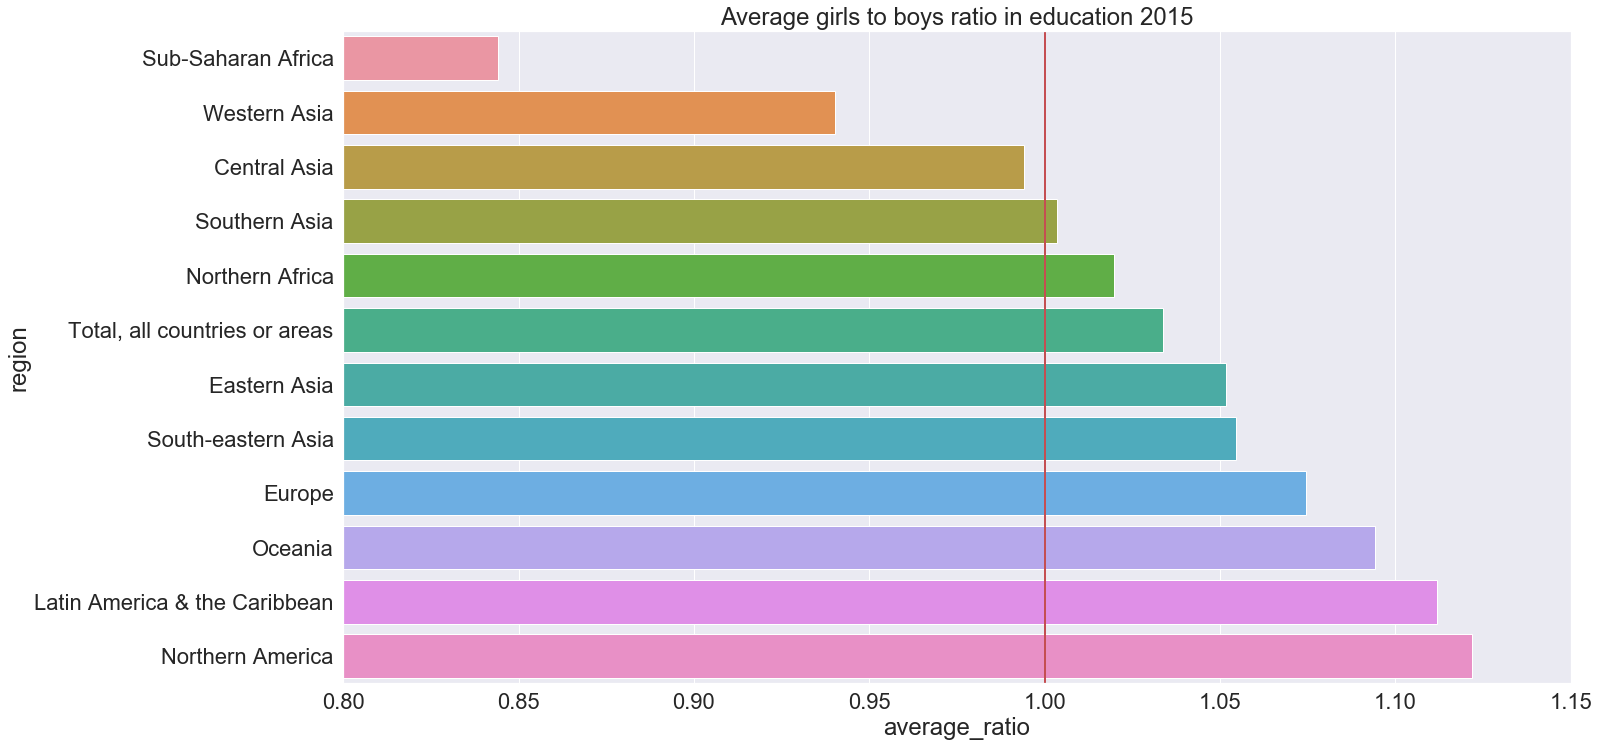

In [34]:
fig = plt.figure(figsize=(22,12))
ax = fig.add_subplot(1, 1, 1)

ax.set_xlim([0.8,1.15])
ax.set(xlabel='', ylabel='')

#Create vertical line in x=1 to represent ratio equality
ax.axvline(x=1,ymin=0, ymax=1,color='r',linewidth = 2)

plt.title("Average girls to boys ratio in education 2015") 
plt.rcParams.update({'font.size': 45})

sns.set(style="darkgrid",font_scale=2)
sns.barplot(x='average_ratio',y='region', data=regions_2015)

plt.show()

Here we can see an average of the ratio in different education stages (primary, secondary and tertiary) for different regions of the world.

Most regions are above the 1:1 ratio, or close to it, except Western Asia (also known as **The Middle East**), and Sub-Saharan Africa, that finds itself with a much worse ratio relative to other regions. A quick google search confirms that this is the case, and that girls acess to education is still a serious issue in the region. As of 2015, [no country in Sub-Saharan Africa has achieved gender equality in primary and secondary education](https://en.unesco.org/gem-report/sites/gem-report/files/SSA_Press_Release_English_Gender_Report2015.pdf).

Interestingly the ratio in Latin America is **higher** than in Europe and Oceania. [This article](http://www.ungei.org/gap/reportLatin.html) explains the progress made in Latin America, and the remaining challenges.

Lets take a look at ratio back in 1985, the earliest year of our data.

In [13]:
query = "SELECT id, region, year, AVG(value) as average_ratio FROM education_cleaned WHERE id IN ({1}) AND year = 1985 GROUP BY id ORDER BY average_ratio"
regions_1985 = sql_to_df(query,regions_id)

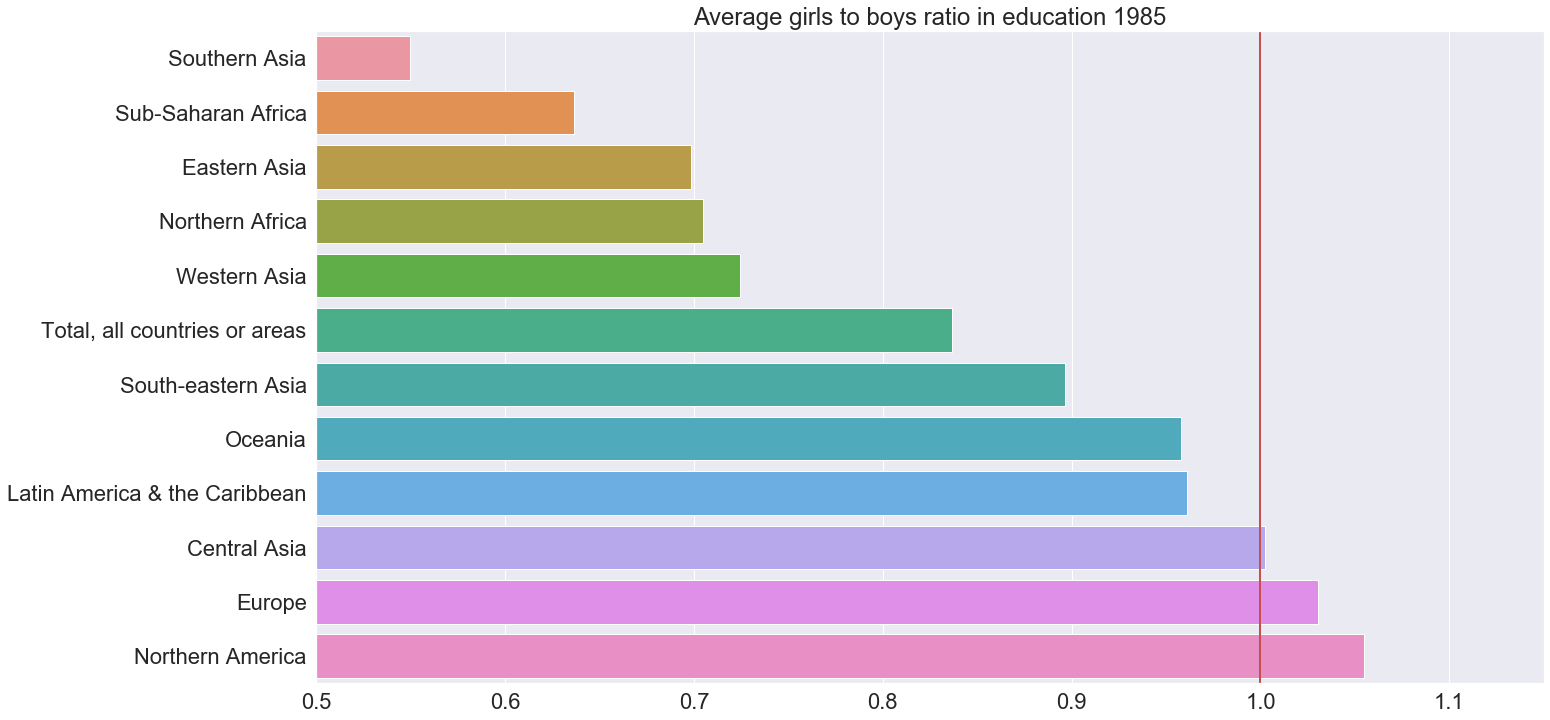

In [14]:
fig = plt.figure(figsize=(22,12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([0.5,1.15])
plt.title("Average girls to boys ratio in education 1985") 
ax.axvline(x=1,ymin=0, ymax=1,color='r',linewidth = 2)



sns.barplot(x='average_ratio',y='region', data=regions_1985)
ax.set(xlabel='', ylabel='')
plt.show()

Where in 2015 all but 3 regions are under the 1:1 ratio, in 1985 only 3 are above!

Apparently Central Asia had a higher average ratio than Oceania and Latin America back in 1985. Investigating the issue a little bit further led me to this [article](https://www.universityworldnews.com/post.php?story=20160707140807406), claiming that the **standard deviation of the ratio in Central Asia is high**, with some countries well above the 1:1 ratio and some under. 

Quoting: 

> Women in Kazakhstan and Kyrgyzstan are more likely than men to enter tertiary education, whereas fewer than 40% of their neighbours in Tajikistan, Turkmenistan and Uzbekistan are studying at this level.

Moving on, lets plot a comparisson between the ratio in each region in 1985 and in 2015 so we can have a better perspective of the progress made until now:

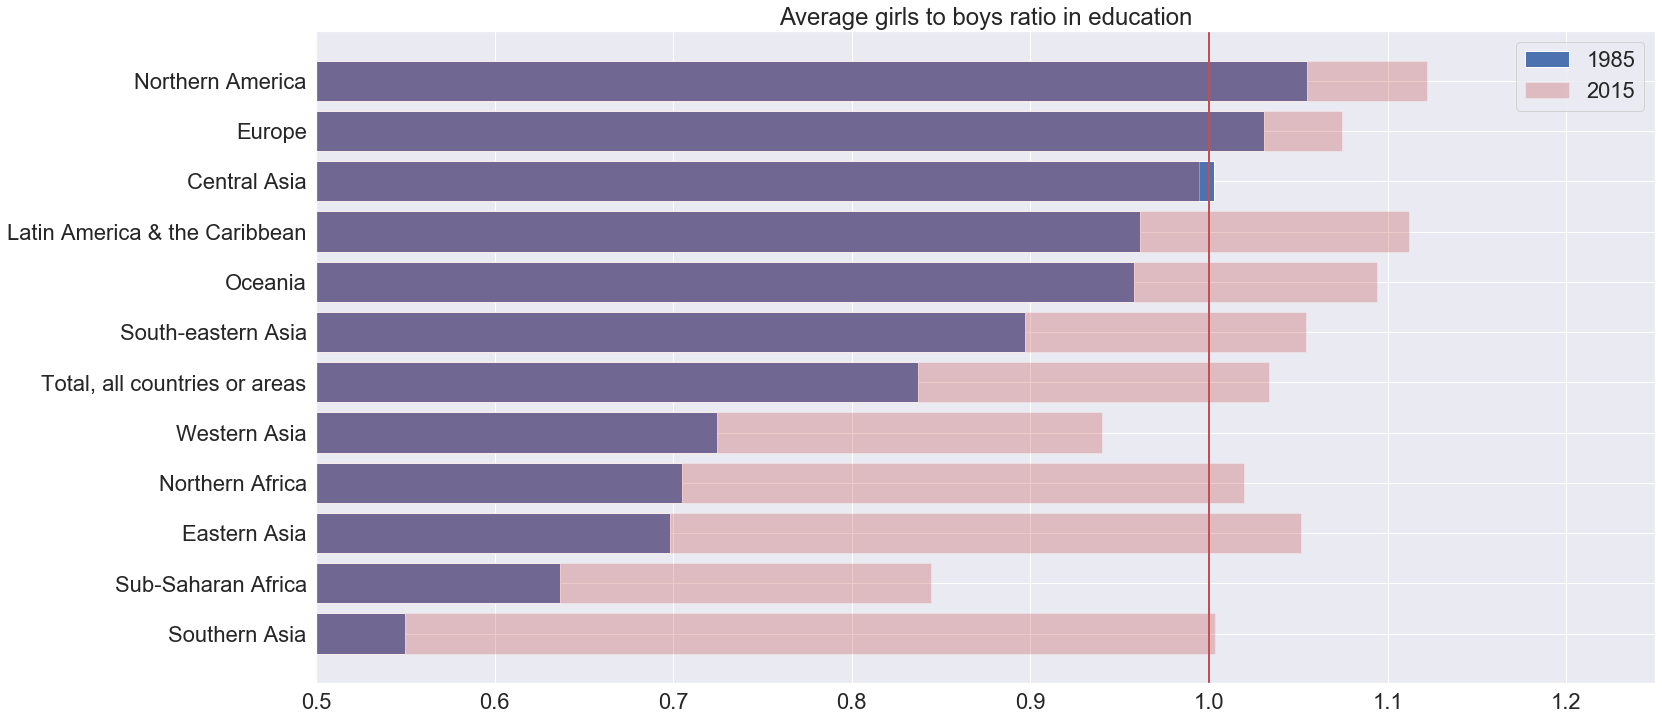

In [15]:
fig = plt.figure(figsize=(24,12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([0.5,1.25])
plt.title("Average girls to boys ratio in education") 
ax.axvline(x=1,ymin=0, ymax=1,color='r',linewidth = 2)
plt.barh(regions_1985.region,regions_1985.average_ratio,color='b',label="1985")
plt.barh(regions_2015.region,regions_2015.average_ratio,color='r',alpha=0.3,label="2015")
plt.legend(loc="upper right")
plt.rcParams.update({'font.size': 25})

ax.set(xlabel='', ylabel='')
plt.show()

This plot illustrates how the progress all over the world has been significant, especially in Southern Asia. It seems that such huge change is owned to India, the most populated country in Southern Asia.

Lets make a line plot so we can see the ratio changing in detail between 1985 and 2015:

In [16]:
query = "SELECT id,region,year,AVG(value) as average_ratio FROM education_cleaned WHERE id IN ({1}) GROUP BY id, year ORDER BY region"
regions_all = sql_to_df(query,regions_id)
regions_all = regions_all[~regions_all.year.isin(["2016","2017","2005"])]

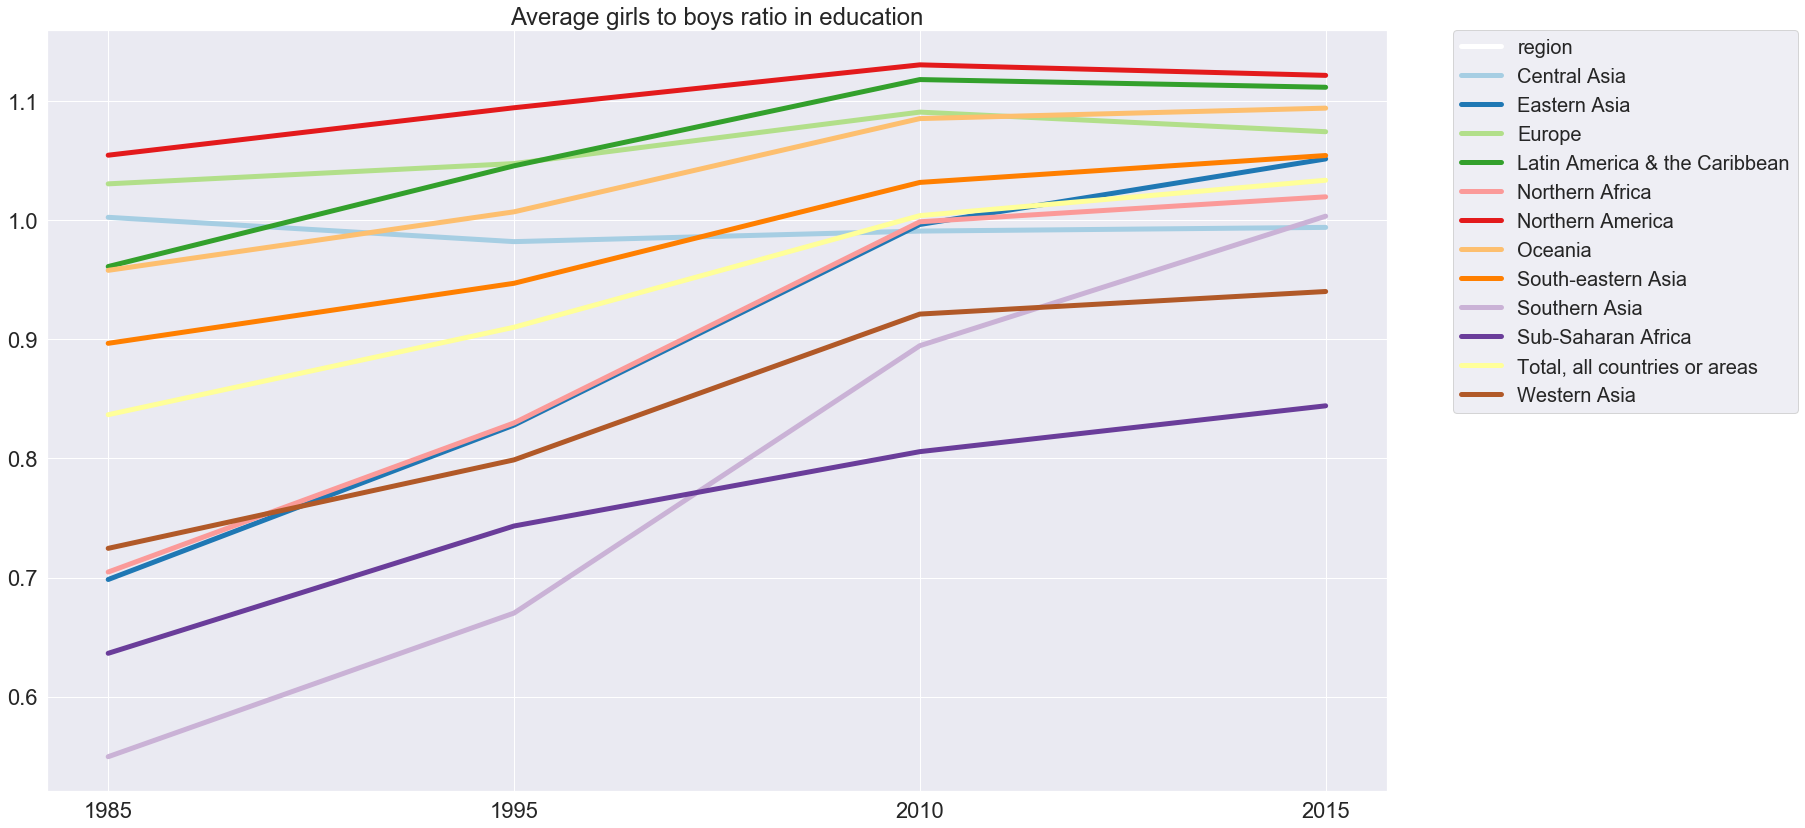

In [17]:
fig = plt.figure(figsize=(24,14))
sns.set(style="darkgrid",font_scale=2)
sns.set_palette(sns.color_palette("Paired"))

plt.title("Average girls to boys ratio in education") 

with sns.color_palette("Paired"):
    ax = sns.lineplot(x="year", y="average_ratio", hue="region", data=regions_all,linewidth=5)

ax.set(xlabel='', ylabel='')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 20})
leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 20})

for line in leg.get_lines():
    line.set_linewidth(5.0)

North America has since 1985 had a higher ratio than other regions. Southern Asia, which once had a lower ratio than Sub-Saharan Africa, has since the year 2000 surpassed the latter, and keeps growing at a much higher rate. In fact is easy to appreciate than from 2010 to 2015 Southern Asia ratio grew at a higher rate than every other region.



The average ratio between primary, secondary and tertiary education gives us an overview on a region general progress towards gender parity, however grouping together tertiary and secondary education ignores one important difference between those two stages of education: income.

According to [Eurostat](https://ec.europa.eu/eurostat/statistics-explained/index.php/Earnings_statistics#Higher_level_of_education_yields_higher_earnings) data, the average salary for those with a high level of education in the EU was approximately 50% higher than those with a medium level of education.

And this is true not only in the EU, in the US a [college graduate will earn an average of 1 million dollars more over their lifetime](https://www.cornerstone.edu/blogs/lifelong-learning-matters/post/do-college-grads-really-earn-more-than-high-school-grads).

So lets take a look at some data on tertiary education:

In [18]:
query = "SELECT id,region,year,value as average_ratio FROM education_cleaned WHERE id IN ({1}) AND education_type LIKE '%tertiary%' ORDER BY region"
regions_tertiary = sql_to_df(query,regions_id)
regions_tertiary.average_ratio = regions_tertiary.average_ratio.astype(str).astype(float)
regions_tertiary.year = regions_tertiary.year.astype(str).astype(float)

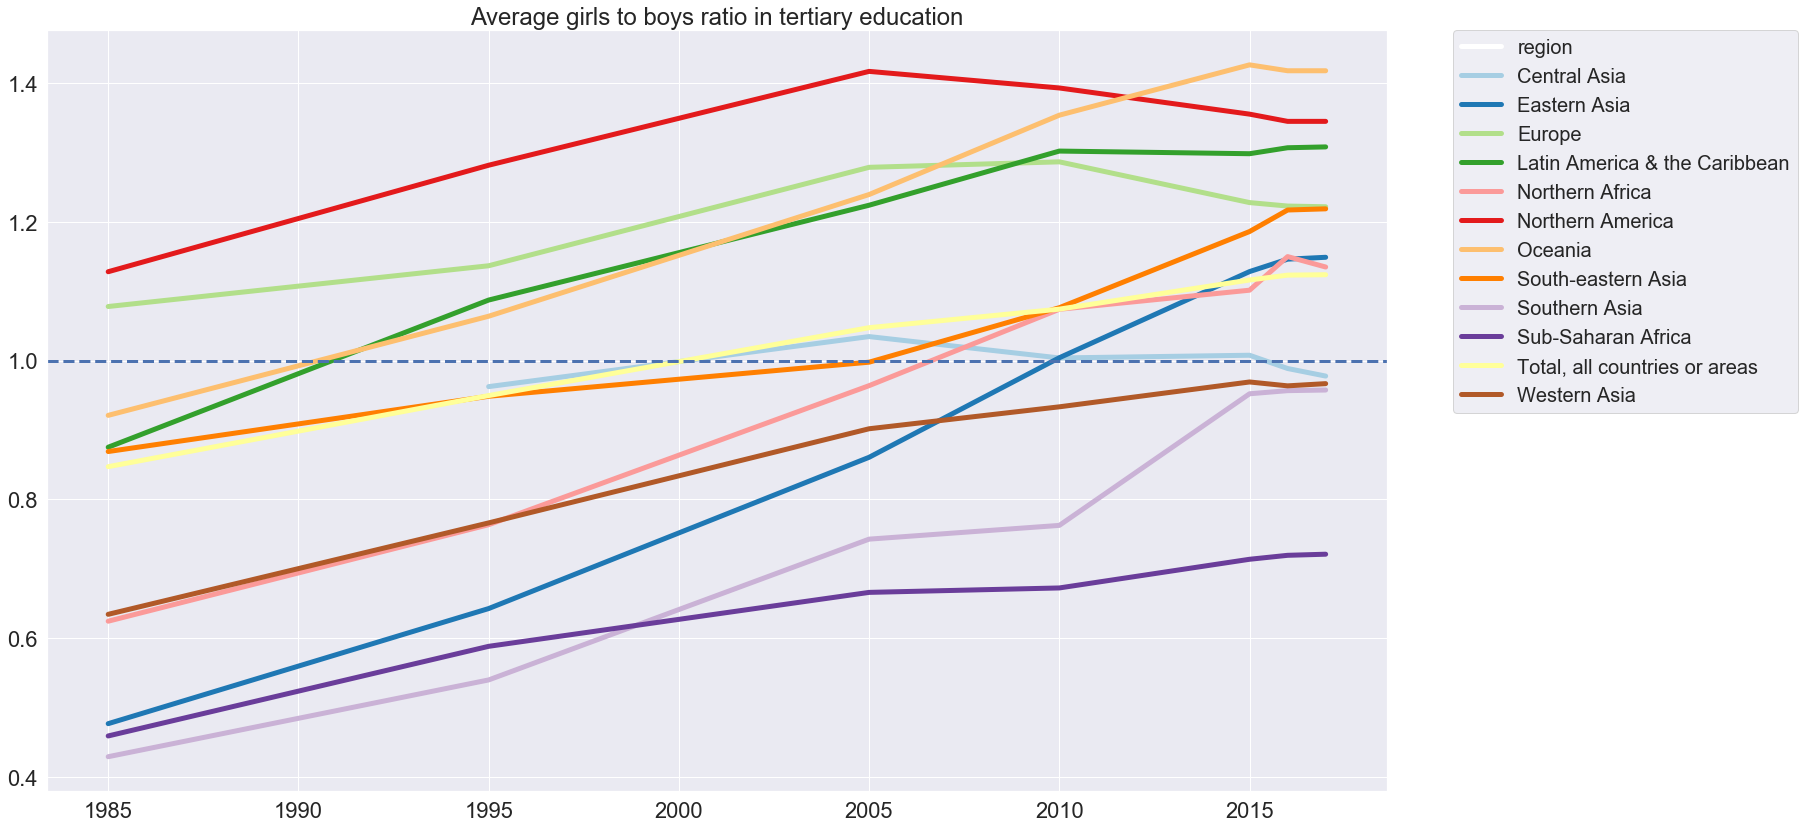

In [19]:
fig = plt.figure(figsize=(24,14))
plt.title("Average girls to boys ratio in tertiary education") 


with sns.color_palette("Paired"):
    ax = sns.lineplot(x="year", y="average_ratio", hue="region", data=regions_tertiary,linewidth=5)

ax.set(xlabel='', ylabel='')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 20})

leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 20})

for line in leg.get_lines():
    line.set_linewidth(5.0)
    
ax.axhline(y=1,color='b',linewidth = 3,ls="--")

This plot clearly shows that when it comes to tertiary education women have outpaced men in most regions of the world. 

In 2015 in the UK women were [35% more likely to go to university than men](https://www.theguardian.com/education/2016/may/12/university-gender-gap-scandal-thinktank-men), and in Spain in the same year [55% of college students were women](https://www.universidadsi.es/incrementa-porcentaje-mujeres-baja-hombres-cursan-estudios-grado/).

Now in many countries [universities and colleges are trying to reverse the trend](https://www.theatlantic.com/education/archive/2017/08/why-men-are-the-new-college-minority/536103/), and trying to attract men back to college.

Is this trend contained to tertiary education? or are boys dropping before? lets compare the different education stages in one plot:

In [20]:
query = "SELECT id,region,year, education_type, value as average_ratio FROM education_cleaned WHERE id IN ({1}) ORDER BY region"
regions_general = sql_to_df(query,regions_id)
regions_general.average_ratio = regions_general.average_ratio.astype(str).astype(float)
regions_general.year = regions_general.year.astype(str).astype(float)

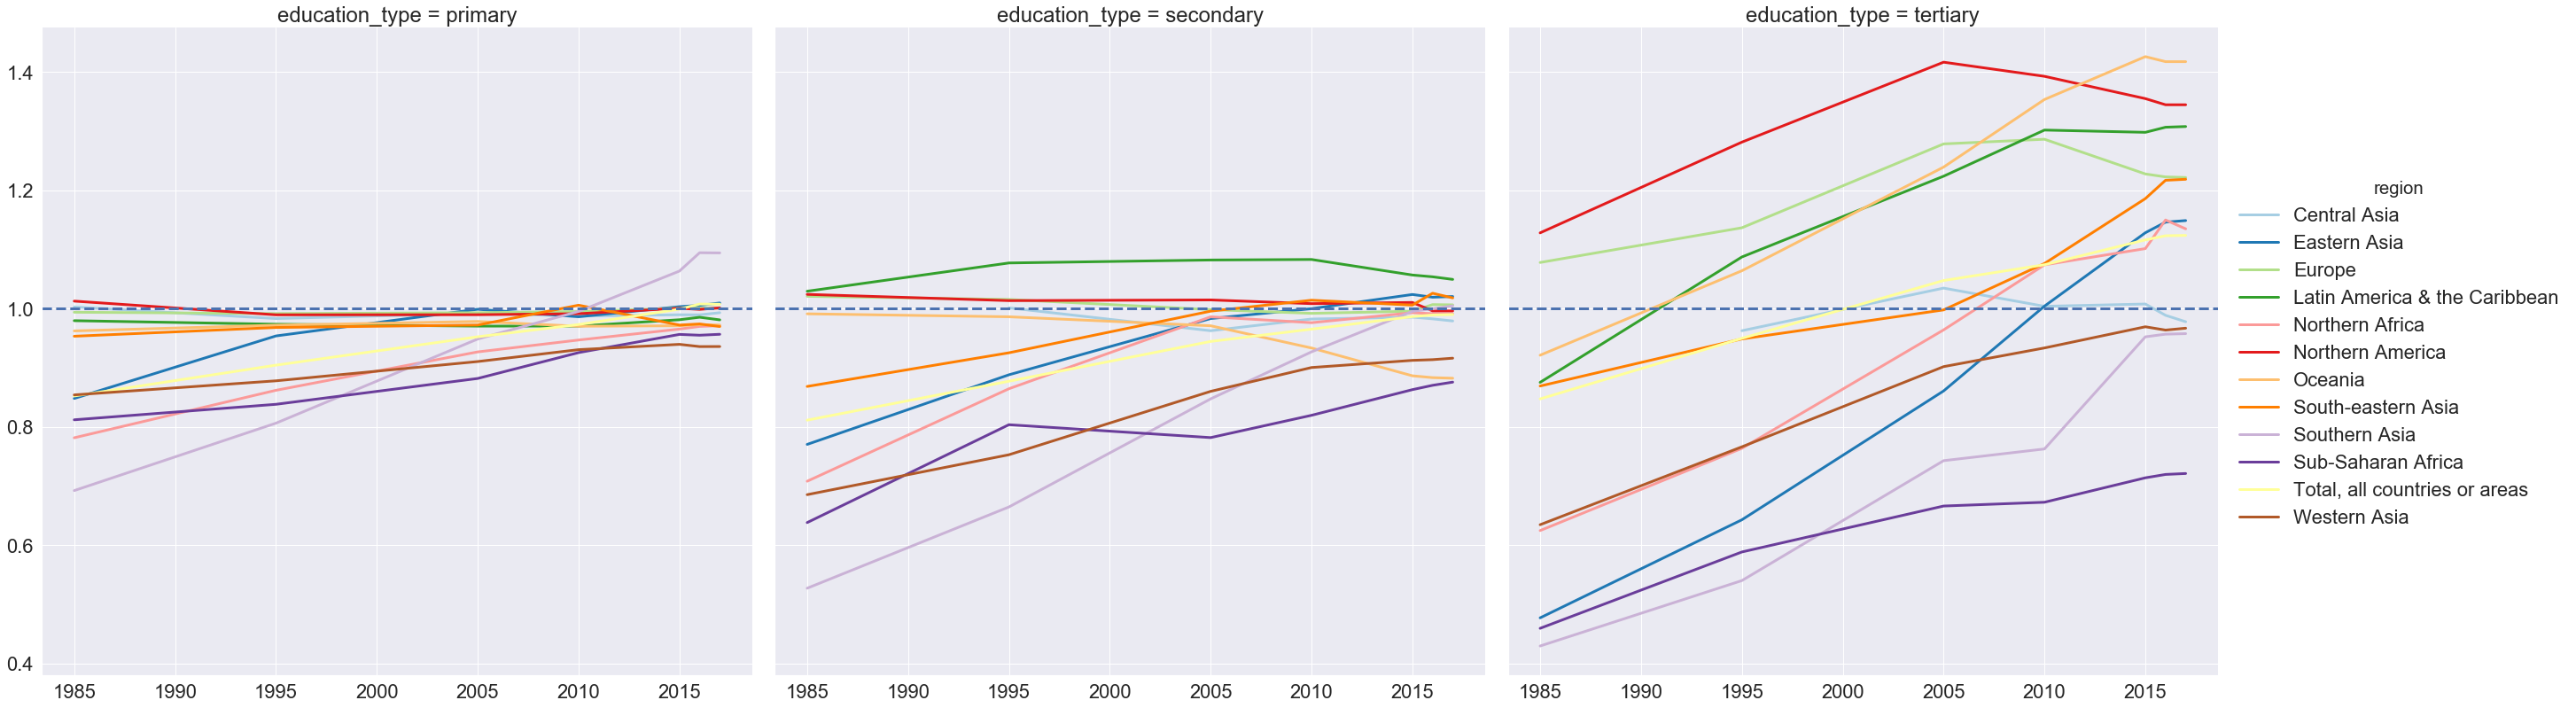

In [21]:
g = sns.FacetGrid(data=regions_general,col='education_type',hue='region',height=12)


sns.set_palette(sns.color_palette("Paired"))
sns.set(font_scale=2)


g = (g.map(sns.lineplot,"year","average_ratio",linewidth=3)).add_legend()

for ax in g.axes.flat:
    ax.axhline(y=1,color='b',linewidth = 3,ls="--")
    ax.set(xlabel='', ylabel='')




In most regions in 2015 the ratio in primary and secondary education were close to 1 or in favor to boys. Only when it comes to tertiary education are boys under a disadvantage, suggesting that boys are dropping out after secondary education at a higher rate than women. Indeed this seems to be an university related problem.

Until now we have been analysing the ratio per region, lets take a look at the ratio per country in 2015:

In [22]:
query = "SELECT id, region, year, AVG(value) as average_ratio FROM education_cleaned WHERE id IN ({1}) AND year = 2015 GROUP BY id,year ORDER BY average_ratio"
countries_2015 = sql_to_df(query,countries_id)
countries_2015=countries_2015.rename(columns = {'region':'country'})

We will use the bokeh module to create a world map plot to represent the ratio of each country in an easy to visualize way.

First I will merge the file with one shapefile containing the location of each country with our countries_2015 dataframe, then I will convert the resulting dataframe to json so I can pass it to bokeh.

In [23]:
shapefile = r'C:\Users\juanv\Desktop\Programming\Projects\shapefiles\ne_110m_admin_0_countries.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
gdf = gdf.drop(gdf.index[159])

In [24]:
countries_2015.at[99,'country'] = 'Russia'
countries_2015.at[52,'country'] = 'Bolivia'
countries_2015.at[80,'country'] = 'Iran'
countries_2015.at[136,'country'] = 'Syria'

In [25]:
#Merging the two dataframes with an outer join
country_geo = pd.merge(gdf, countries_2015, on='country', how='outer') 
country_geo = country_geo.drop(columns=['id', 'country_code'])
#Filling NA values with 'No data' for json convertion
country_geo = country_geo[country_geo['geometry'].notna()]
country_geo.average_ratio.fillna('No data', inplace = True)

In [26]:
import json
#Read data to json.

var = country_geo.to_json()
merged_json = json.loads(var)

#Convert to String like object.
json_data = json.dumps(merged_json)

In [27]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)
#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0.3, high = 1.51)
#Define custom tick labels for color bar.
tick_labels = {'0.4': '0.4', '0.6': '0.6', '0.8':'0.8', '1':'1', '1.2':'1.2', '1.4':'1.4', '1.5':'> 1.5'}
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal')
#Create figure object.
p = figure(title = 'Girls to boys ration in education, 2015', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'average_ratio', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

p.add_layout(color_bar, 'below')
output_notebook()

show(p)

Loading BokehJS ...

As expected sub-saharan africa contains several countries under the 1:1 equality ratio.

Lets study the median, the quartiles and the interquartile range of the average ratio per country in 2015 and in 1985.

{'whiskers': [<matplotlib.lines.Line2D at 0x2091bb94bc8>,
 'caps': [<matplotlib.lines.Line2D at 0x2091bb9cd08>,
 'boxes': [<matplotlib.lines.Line2D at 0x2091bb8df08>],
 'medians': [<matplotlib.lines.Line2D at 0x2091bba0e08>],
 'fliers': [],
 'means': []}

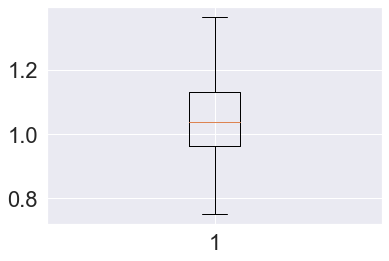

In [28]:
plt.boxplot(countries_2015.average_ratio,showfliers=False)

in 2015 50% of the countries had an average ratio between slightly below 1 and around 1.1, with only 25% of the countries having a ratio of less than 0.96-0.98.

In [29]:
query = "SELECT id, region, year, AVG(value) as average_ratio FROM education_cleaned WHERE id IN ({1}) AND year = 1985 GROUP BY id ORDER BY average_ratio"
query = query.format("?",",".join("?"*len(countries_id)))
countries_1985 = pd.read_sql_query(query,conn,params=countries_id)

{'whiskers': [<matplotlib.lines.Line2D at 0x2091ba81608>,
 'caps': [<matplotlib.lines.Line2D at 0x2091ba81f08>,
 'boxes': [<matplotlib.lines.Line2D at 0x2091ba7eb88>],
 'medians': [<matplotlib.lines.Line2D at 0x2091ba85e88>],
 'fliers': [],
 'means': []}

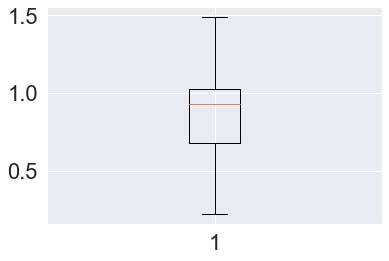

In [30]:
plt.boxplot(countries_1985.average_ratio,showfliers=False)

However in 1985 75% of the countries in the world had an average ratio of under 1! 

50% were contained between around 0.6 and 1.

The much higher interquartile range in 1985 also indicates a higher variability. This seems to indicate that countries around the world are converging at the same 1:1 ratio of girls to boys in education.

To end this analysis, lets create a line plot of the world average of the ratio in each education stage:

In [31]:
query = "SELECT id,region,year, education_type, value as ratio FROM education_cleaned WHERE id IN ({1}) ORDER BY year"
world = sql_to_df(query,world_id)
world.ratio = world.ratio.astype('float')

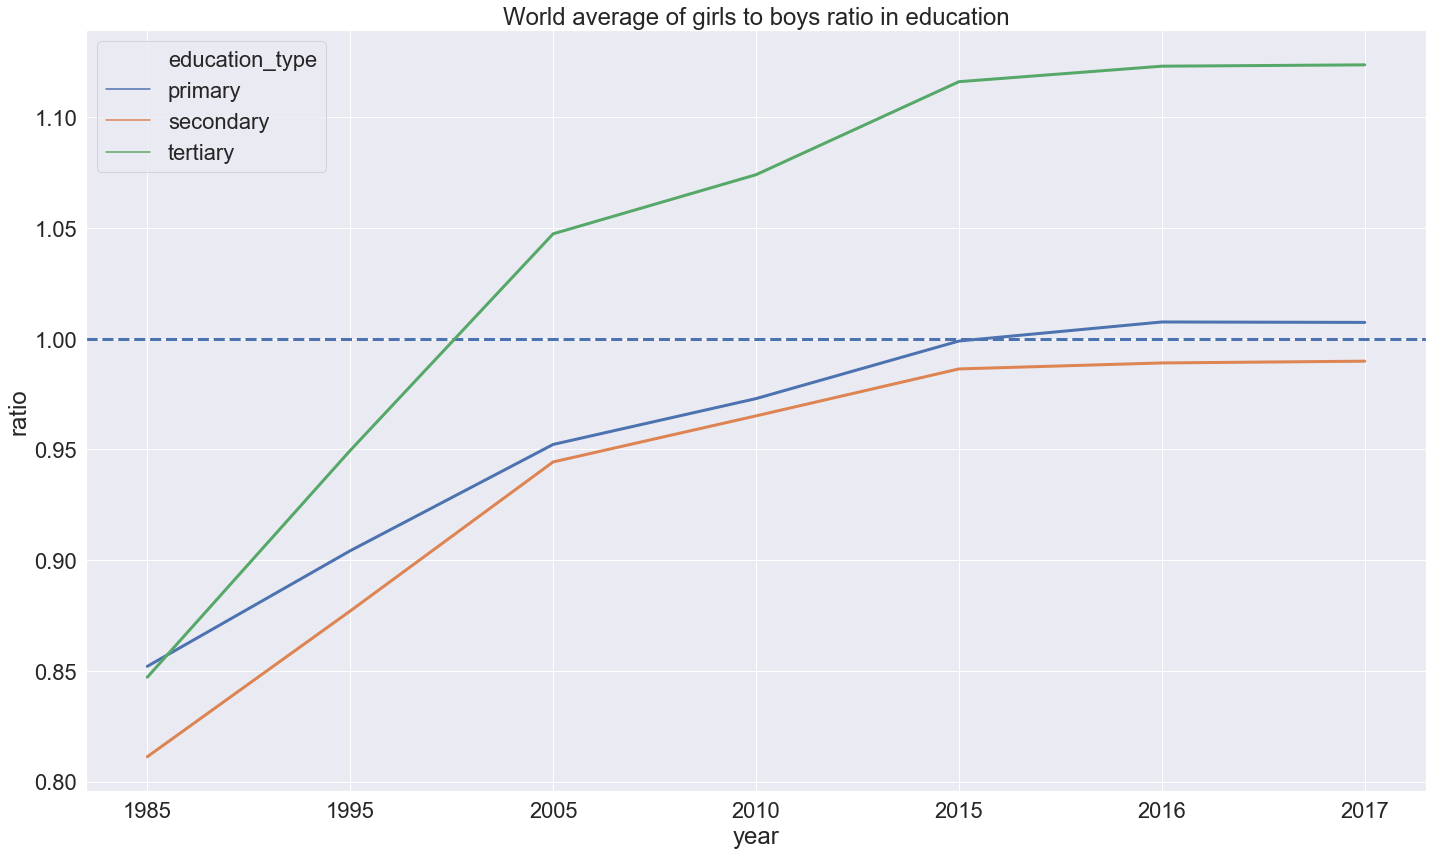

In [32]:
fig = plt.figure(figsize=(24,14))
ax = fig.add_subplot(1, 1, 1)
plt.title("World average of girls to boys ratio in education") 

ax.axhline(y=1,color='b',linewidth = 3,ls="--")

ax.set(xlabel='', ylabel='')

ax = sns.lineplot(data=world,x="year",y="ratio",hue='education_type',linewidth=3)

Enormous progress has been made since 1985 around the world. It seems now that on average there is the same ratio of girls to boys in both primary and secondary education in the world, while girls are significantly outpacing boys in tertiary education since the year 2000.

In [33]:
cursor.execute("DROP TABLE education_cleaned")

## Source: 
United Nations Statistics Division. The link to download the dataset is: http://data.un.org/_Docs/SYB/CSV/SYB62_319_201906_Ratio%20of%20Girls%20to%20Boys%20in%20Education.csv